# Summary
In this notebook I adapt the pretrained model **MobileNetV2** to classify images of Alpacas.

# The dataset
The dataset consists of images organize in two folders: `alpaca` (containing images of alpacas) and `not alpaca` (containing images that are not alpacas). This organization is useful because I will be using an image loader that label the images by reading the subdirectories.

## Prepared the data
I use `image_data_set_from_directory()`, which loads the data, creates training and validation sets, shuffle the data, and create batches.

In [6]:
# Hyperparameters
batch_s = 32
image_s = (160, 160)

In [7]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf

directory = "/kaggle/input/alpaca-dataset-small/dataset"

# Training set
train_set = image_dataset_from_directory(directory, shuffle=True,
                                        batch_size=batch_s,
                                        image_size=image_s,
                                        validation_split=0.2,
                                        subset='training',
                                        seed=0)

# Validation set
valid_set = image_dataset_from_directory(directory, shuffle=True,
                                        batch_size=batch_s,
                                        image_size=image_s,
                                        validation_split=0.2,
                                        subset='validation',
                                        seed=0)

# Boost train_set
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_set = train_set.prefetch(buffer_size=AUTOTUNE)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


## Preprocessing


## Data augmentation
I create a small sequential keras model that applies data augmentation.

In [12]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

# Data augmenter
augmentator = Sequential([
    RandomFlip('vertical'),
    RandomRotation(0.3)
])

## Normalization
**MobileNetV2** was trained on a range of normalization values of [-1, 1], so I reuse the same range.

In [14]:
preprocessor = tf.keras.applications.mobilenet_v2.preprocess_input

# Modeling
I adapt the mobilenetv2 model to classify alpaca images.

In [15]:
# Instatiate MobileNetV2 model
pretrained = tf.keras.applications.MobileNetV2(input_shape=image_s + (3,),
                                              include_top=False,
                                              weights='imagenet')

# Freeze pretrained model layers
pretrained.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [19]:
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout

inputs = Input(shape=image_s + (3,))

# Augmentation
x = augmentator(inputs)

# Preprocessing
x = preprocessor(x)

# Pretrained model
x = pretrained(x, training=False)

# Binary classification task

x = Flatten()(x)
x = Dropout(0.3)(x)
y_pred = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[inputs], outputs=[y_pred])

In [20]:
# Compiling
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [21]:
# Training
n_epochs=6

history = model.fit(train_set, validation_data=valid_set, epochs=n_epochs)

Epoch 1/6
9/9 [==============================] - 11s 612ms/step - loss: 1.1484 - accuracy: 0.6260 - val_loss: 0.5756 - val_accuracy: 0.8154
Epoch 2/6
9/9 [==============================] - 4s 392ms/step - loss: 0.5661 - accuracy: 0.8244 - val_loss: 0.3681 - val_accuracy: 0.8923
Epoch 3/6
9/9 [==============================] - 5s 450ms/step - loss: 0.3604 - accuracy: 0.8664 - val_loss: 0.2713 - val_accuracy: 0.9385
Epoch 4/6
9/9 [==============================] - 5s 408ms/step - loss: 0.4295 - accuracy: 0.8664 - val_loss: 0.2271 - val_accuracy: 0.9385
Epoch 5/6
9/9 [==============================] - 4s 361ms/step - loss: 0.3457 - accuracy: 0.8779 - val_loss: 0.3220 - val_accuracy: 0.9385
Epoch 6/6
9/9 [==============================] - 5s 438ms/step - loss: 0.2715 - accuracy: 0.8969 - val_loss: 0.2891 - val_accuracy: 0.9385


# Evaluation

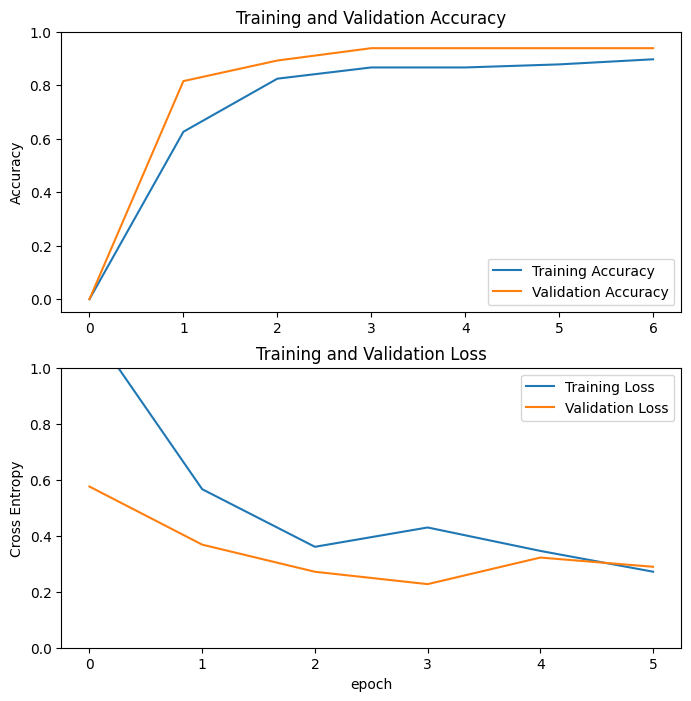

In [23]:
import matplotlib.pyplot as plt

acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()